In [1]:
%matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression, RFE, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

import shap
from shap import SamplingExplainer

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

import glob
import os
import json

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [2]:
label_col = params.label_col

pd.set_option('display.max_columns', None)

df_feat_all = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)
features_cols = df_feat_all.columns.drop(['bid', 'ask', 'signal'])

# we applied the feature engineering over the whole time span,
# but we calculate the feature importance only on the regular trading time
df_feat_filt = df_feat_all.between_time(params.sess_start, params.sess_end).drop(['bid','ask'], axis=1)
df_feat_filt

,bb_lband,bb_hband,atr_14,atr_sma,obv,obv_sma,open,high,low,close,volume,r_1,r_5,r_15,vol_15,bb_width_20,rsi,atr_ratio,atr_ratio_sma,vwap_dev,volume_spike,stoch_k_14,stoch_d_3,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div,hour,day_of_week,month,signal
2004-01-02 14:30:00,-1.389565,18.156422,256.117641,34.842535,-0.341223,-0.831289,8.696203,14.097046,8.156118,13.016878,3.571632,1.821543,2.382916,3.359414,-0.646699,2.476893,2.367345,0.337452,-0.567023,2.011532,3.221255,1.322746,1.443536,0.170256,0.001484,0.031624,-1.404509,0.626918,0.529308,3.042683,0.263,-0.976,0.476,1.000000
2004-01-02 14:31:00,-1.022982,19.889022,363.734826,43.448798,-0.283883,-0.776997,8.575000,16.041667,8.041667,14.441667,1.054125,1.819018,2.913437,3.658336,-0.521965,2.647030,2.375622,0.853504,-0.478206,2.247859,0.879842,1.217770,1.351437,0.170256,0.001484,0.031624,-1.412837,0.606833,0.585061,4.457310,0.263,-0.976,0.476,1.000000
2004-01-02 14:32:00,-1.333936,23.194788,54.211456,46.249912,-0.178979,-0.724214,14.461728,18.991770,12.670782,18.991770,3.116635,5.442699,5.129476,4.956139,0.537651,3.226620,2.389727,1.202631,-0.374153,2.969582,2.410342,1.278743,1.300861,0.227411,0.260160,-0.026475,-1.427029,0.717081,0.746163,5.289444,0.263,-0.976,0.476,0.760206
2004-01-02 14:33:00,-1.101670,25.733829,30.194763,45.003809,-0.186246,-0.677233,18.227642,18.747967,16.146341,18.227642,-0.025140,-0.604034,4.395970,4.587440,0.627049,3.562996,2.188306,1.250002,-0.269786,2.856367,-0.212360,1.343869,1.308053,0.227411,0.260160,0.031624,-1.224104,0.640284,0.640951,5.081410,0.263,-0.976,0.476,0.000000
2004-01-02 14:34:00,-0.534287,27.214228,21.484083,41.708283,-0.199155,-0.637735,16.707681,17.184937,14.798658,14.798658,0.230058,-2.417828,2.819213,3.718930,0.962782,3.617211,1.482413,1.297274,-0.164960,2.466958,0.011116,1.275249,1.327626,0.227411,0.260160,0.089722,-0.513031,1.071231,0.528174,4.914984,0.263,-0.976,0.476,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18 18:08:00,0.560850,0.613678,-0.175800,-0.204833,1.392702,1.358300,0.832153,0.922252,0.863132,0.890587,0.558560,0.492225,0.608668,0.497626,-0.326719,-0.422206,0.473578,-0.276107,-0.256492,0.921605,-0.303565,1.140143,0.854045,0.113101,4.398978,-6.765915,0.503267,-0.027995,0.067182,-0.077819,-0.695,0.039,-0.523,0.046700
2020-11-18 18:09:00,0.548929,0.649351,-0.224123,-0.204938,1.406676,1.350663,0.944676,0.936170,0.931613,0.919800,0.613821,0.218993,0.660136,0.585939,-0.324222,-0.374080,0.561072,-0.301915,-0.256245,0.952229,-0.239927,1.264180,1.110539,1.027582,5.433682,-7.550247,0.415159,-0.027995,0.080396,-0.161032,-0.695,0.039,-0.523,0.011572
2020-11-18 18:10:00,0.563000,0.601293,-0.181790,-0.204358,1.389568,1.341682,0.949685,0.925532,0.800616,0.724900,0.637166,-1.042632,0.203467,0.346506,-0.294473,-0.429001,-0.008135,-0.280813,-0.256521,0.795552,-0.199846,1.029561,1.169636,1.141892,4.140302,-4.558168,0.988551,-0.027995,0.058499,-0.077819,-0.695,0.039,-0.523,0.013253
2020-11-18 18:11:00,0.560820,0.578341,-0.149298,-0.202624,1.371554,1.337559,0.748718,0.719577,0.612182,0.558600,0.731303,-0.886394,-0.362305,0.026603,-0.275381,-0.440832,-0.369370,-0.264939,-0.256215,0.662305,-0.103702,0.350629,0.900796,0.684652,1.812217,-2.292321,1.352465,-0.027995,0.034415,-0.036212,-0.695,0.039,-0.523,0.037004


In [3]:
# Prepare the master dict of feature importances
features_importances = {
    feat: {}
    for feat in features_cols
} 

X = df_feat_filt[features_cols]
y = df_feat_filt[label_col]

In [4]:
# Utility: update the dict
def update_feature_importances(fi_dict, importance_type, values: pd.Series):
    """
    fi_dict: master dict
    importance_type: one of "corr","mi","perm","shap","lasso"
    values: pd.Series indexed by feature name
    """
    for feat, val in values.items():
        if feat in fi_dict:
            fi_dict[feat][importance_type] = val


In [5]:
def live_feature_importance(
    df: pd.DataFrame,
    features: list[str],
    label: str,
    method: str,               # "corr", "mi", "perm", "shap", "lasso"
    compute_fn,                # function(feature_name) → importance_value
    threshold: float = None
):
    """
    Generic live plotter for a sequence of feature importances.
    
    - df        : full dataframe
    - features  : list of column names to score
    - label     : target column name (for context in title)
    - method    : text legend ("Corr", "Mutual Info", etc.)
    - compute_fn: a callable f → score[f]
    - threshold : optional vertical line in the bar chart
    """
    # accumulator
    scores = {}

    # loop with progress bar
    for f in tqdm(features, desc=f"{method}"):
        # compute
        val = compute_fn(f)
        scores[f] = val

        # update on‐screen plot
        clear_output(wait=True)
        series = pd.Series(scores).sort_values()
        plt.figure(figsize=(6, max(3, len(series)*0.25)))
        sns.barplot(x=series.values, y=series.index, palette="vlag")
        if threshold is not None:
            plt.axvline(threshold, color="gray", linestyle="--")
            if method=="Corr":
                plt.axvline(-threshold, color="gray", linestyle="--")
        plt.title(f"{method} Importance (partial) for {label}")
        plt.xlabel("Importance")
        plt.tight_layout()
        display(plt.gcf())
        plt.close()

        # tiny pause so the UI can breathe (optional)
        time.sleep(0.02)

    # final return
    return pd.Series(scores).sort_values()

/tmp/ipykernel_657/1271647419.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series.values, y=series.index, palette="vlag")


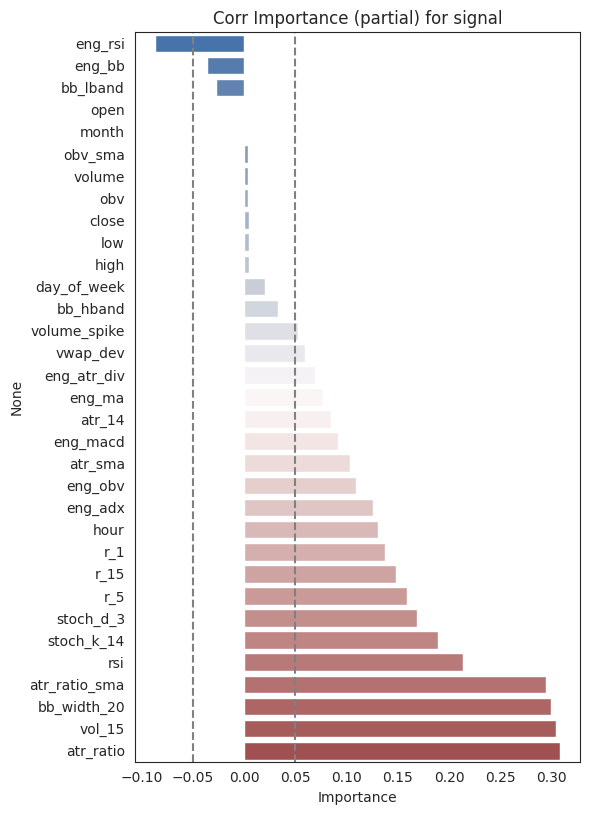

In [6]:
'''
# 1) Correlation live

This method uses Pearson’s correlation coefficient to quantify the linear relationship
between each input feature and the target variable.  A coefficient ρ close to ±1
indicates a strong linear association (positive or negative), whereas a value near 0
suggests little to no linear dependency.

How this function works:
  • For every feature f in your dataset, compute ρ = corr(f, y), the correlation with y.  
  • The helper live_feature_importance streams an updating bar chart as you loop
    through features, hiding any whose |ρ| falls below a threshold (here 0.05).  
  • At the end, you get a pd.Series of all ρ values, sorted by magnitude.  
  • Finally, update_feature_importances stores that series under the key "corr"
    in your master dictionary, so you can compare correlation importance alongside
    other measures.
'''


def corr_fn(feat):
    return df_feat_filt[feat].corr(df_feat_filt[label_col])

corr_scores = live_feature_importance(
    df_feat_filt,
    features_cols,
    label_col,
    method="Corr",
    compute_fn=corr_fn,
    threshold=0.05
)

update_feature_importances(features_importances, "corr", corr_scores)


/tmp/ipykernel_657/1271647419.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series.values, y=series.index, palette="vlag")


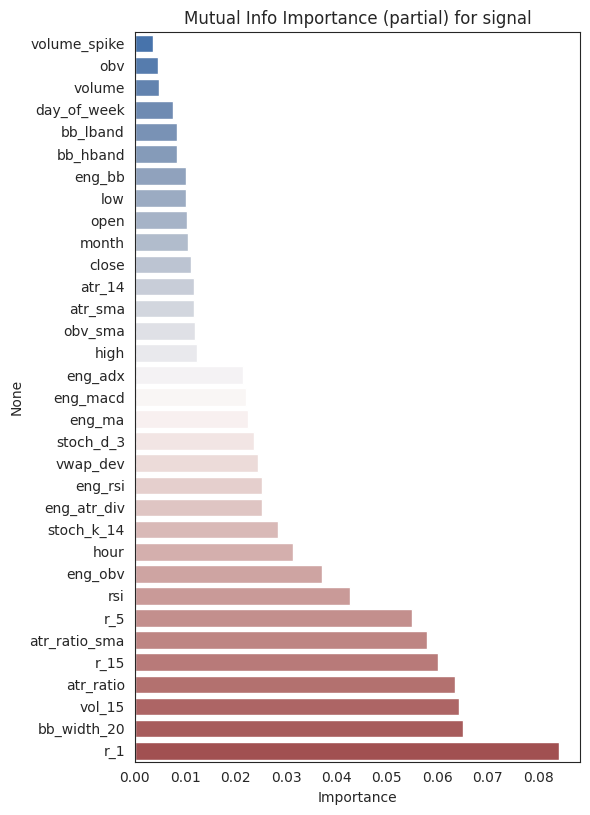

In [7]:
'''
# 2) Mutual Information live

Mutual Information (MI) measures any statistical dependency—linear or non‐linear—
between a feature and the target.  It captures how much knowing the feature
reduces uncertainty about the target, with higher MI indicating stronger dependency.

How this function works:
  • For each feature, call scikit‐learn’s mutual_info_regression, which
    nonparametrically estimates MI between that feature and y.  
  • live_feature_importance streams a bar chart as MI values accumulate,
    highlighting features in order of increasing MI.  
  • A threshold of zero ensures all features appear in the live plot.  
  • Finally, we record the resulting MI scores in your master dict under "mi",
    ready for downstream comparison.
'''


def mi_fn(feat):
    return mutual_info_regression(
        df_feat_filt[[feat]].fillna(0),
        df_feat_filt[label_col],
        discrete_features=False,
        random_state=0
    )[0]

mi_scores = live_feature_importance(
    df_feat_filt,
    features_cols,
    label_col,
    method="Mutual Info",
    compute_fn=mi_fn,
    threshold=0.0
)

update_feature_importances(features_importances, "mi", mi_scores)


/tmp/ipykernel_657/1271647419.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series.values, y=series.index, palette="vlag")


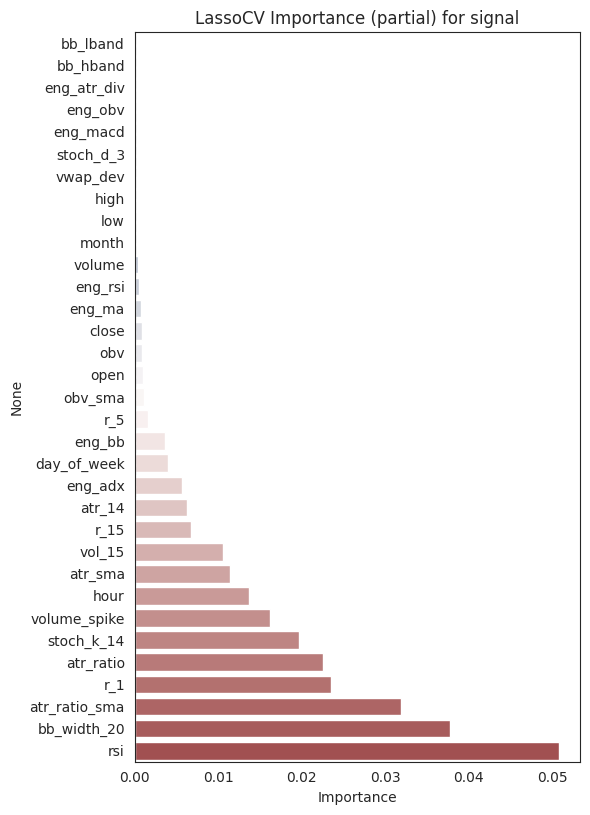

In [8]:
'''
# 3) Lasso live (coordinate descent)

Lasso regression augments ordinary least‐squares with an ℓ₁ penalty on coefficients,
forcing many weights to zero and performing built‐in feature selection.  Through
cross‐validation, it picks the regularization strength α that best balances bias
vs. sparsity.

How this function works:
  1. Standardize X and center y so penalties are comparable across features.  
  2. Fit LassoCV over a logarithmic grid of α values with k‐fold CV to choose α.  
  3. Once α is selected, take the absolute value of each coefficient as its “importance.”  
  4. Stream‐plot these absolute coefficients with live_feature_importance, letting
     you watch features sorted by their weight magnitude.  
  5. Store the final |coefficients| Series under the key "lasso" in your
     features_importances dict.
'''


# 1) Standardize X and y
scaler = StandardScaler()
Xz = scaler.fit_transform(X)
yz = y - y.mean()

# 2) Fit LassoCV once for all features
lasso_cv = LassoCV(
    alphas=np.logspace(-4, -1, 20), # Densify your α grid (np.logspace(-4, -1, 20) → np.logspace(-6, 0, 100))
    cv=5, # increase the number of CV folds (cv=5 → cv=10 or 20) to reduce variance in α
    max_iter=10000, # Raise max_iter or tighten tol so the solver truly converges on each α.
    random_state=0
).fit(Xz, yz)

# 3) Build a Series of |coefficients|
lasso_scores = pd.Series(
    np.abs(lasso_cv.coef_),
    index=features_cols
).sort_values()

# 4) Stream‐plot via our helper
def lasso_cv_fn(feat):
    return lasso_scores[feat]

_ = live_feature_importance(
    df_feat_filt,
    features_cols,
    label_col,
    method="LassoCV",
    compute_fn=lasso_cv_fn,
    threshold=0.0
)

# 5) Store
update_feature_importances(features_importances, "lasso", lasso_scores)



In [ ]:
# ────────────────────────────────────────────────────────────────────
# Incremental RF fit with warm_start + tqdm
# ────────────────────────────────────────────────────────────────────

'''
Initialize a warm‐start RandomForest,
grow it one tree at a time up to TARGET_TREES,
so we can reuse the same fitted model for RFE, permutation importance, and SHAP.
'''

rf = RandomForestRegressor(
    warm_start=True,
    n_estimators=25, # Using a larger forest (n_estimators) to stabilize .feature_importances_ (slower)
    max_depth=5,
    n_jobs=-1,
    random_state=0
)

TARGET_TREES = 20
for i in tqdm(range(TARGET_TREES), desc="Training RF trees"):
    rf.set_params(n_estimators=i + 1)
    rf.fit(X, y)


Training RF trees:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
'''
# 4) RFE live (recursive feature elimination with CV)

Recursive Feature Elimination (RFE) is a wrapper approach that repeatedly fits
a model, ranks features by importance, drops the weakest feature, and refits
until only the desired number remain.  This process exposes interactions and
collinearity effects as the feature set shrinks.

How this function works:
  • Start with your full feature list and clone a fresh RF each iteration.  
  • Fit the RF on the current subset, extract raw .feature_importances_.  
  • Use live_feature_importance to stream‐plot importance bars—dropped features
    show zero importance once eliminated.  
  • Drop the single least‐important feature and repeat until you keep
    n_features_to_keep survivors.  
  • Fit one final RF on those survivors, stream the final plot, and then
    call update_feature_importances exactly once, saving that last importance
    Series under "rfe".
'''

remaining = features_cols.copy()
# how many features you want at the end
n_features_to_keep = len(remaining)  # this way it runs only once to save time (but a lower number should be set here)

rounds = len(remaining) - n_features_to_keep

from sklearn.model_selection import KFold

for i in range(rounds):
    # cross-validate RF on current subset to get stable importances
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    imps_list = []
    for train_idx, val_idx in kf.split(df_feat_filt):
        model_cv = clone(rf)
        model_cv.warm_start = False
        model_cv.fit(df_feat_filt.iloc[train_idx][remaining], df_feat_filt.iloc[train_idx][label_col])
        imps_list.append(pd.Series(
            model_cv.feature_importances_,
            index=remaining
        ))

    # average importances across folds
    imps = pd.concat(imps_list, axis=1).mean(axis=1)

    # compute_fn returns 0.0 for dropped features
    def compute_fn(feat, imps=imps):
        return float(imps.get(feat, 0.0))

    # live‐plot
    _ = live_feature_importance(
        df=df_feat_filt,
        features=features_cols,             # full list for consistent axis
        label=label_col,                    # <-- correct arg name
        method=f"RFE round {i+1}",
        compute_fn=compute_fn,
        threshold=0.0
    )
    plt.show()                              # force display

    # drop the least‐important feature
    worst = imps.idxmin()
    remaining.remove(worst)

# final fit on survivors
final = clone(rf)
final.warm_start = False
final.fit(df_feat_filt[remaining], df_feat_filt[label_col])

final_imps = pd.Series(final.feature_importances_, index=remaining)

# final live‐plot
_ = live_feature_importance(
    df=df_feat_filt,
    features=features_cols,
    label=label_col,
    method="RFE final",
    compute_fn=lambda feat: float(final_imps.get(feat, 0.0)),
    threshold=0.0
)
plt.show()

# save only the final importances
update_feature_importances(
    fi_dict=features_importances,
    importance_type="rfe",
    values=final_imps
)


In [ ]:
'''
# 5) Permutation Importance live (RF) — CV-based

Permutation importance measures feature impact on model performance by
randomly shuffling one feature’s values and observing the increase in
prediction error.  Unlike impurity importances, it reflects the model’s
dependence on each feature in held‐out data.

How this function works:
  A) Impurity importances:
     • Grab rf.feature_importances_ from the in‐memory forest and store them
       under "impurity" (never zero because every tree splits somewhere).  
  B) CV-based permutation:
     • Perform k‐fold cross‐validation.  In each fold, fit the RF on train,
       permute one feature in test, measure the Δ‐MSE, and record the mean
       drop over multiple repeats.  
     • Average these Δ‐MSE drops across folds to get a stable permutation score.  
  C) Streaming:
     • Use live_feature_importance to display these CV‐based permutation scores
       in real time.  
  D) Storage:
     • Store the final averaged permutation Series under "perm" in your dict.
'''


# A) Impurity-based importance (never zero)
impurity_imp = pd.Series(rf.feature_importances_, index=features_cols)
update_feature_importances(features_importances, "perm_imp", impurity_imp)

# B) CV-based permutation importance
kf = KFold(n_splits=10, shuffle=True, random_state=0) # boost stability by increasing n_splits
perm_scores = []

for train_idx, test_idx in kf.split(X):
    rf.fit(X.iloc[train_idx], y.iloc[train_idx])
    pi = permutation_importance(
        rf,
        X.iloc[test_idx],
        y.iloc[test_idx],
        n_repeats=30, # boost stability by increasing the number of repeats (n_repeats=10 → 30 or 50)
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        random_state=0
    )
    perm_scores.append(pi.importances_mean)

perm_mean = np.mean(perm_scores, axis=0)
perm_scores_mean = pd.Series(perm_mean, index=features_cols)
update_feature_importances(features_importances, "perm_CV", perm_scores_mean)

# C) live plotting via our helper
def perm_fn(feat):
    return perm_scores_mean[feat]

perm_scores_live = live_feature_importance(
    df_feat_filt,
    features_cols,
    label_col,
    method="CV-Permute RF",
    compute_fn=perm_fn,
    threshold=0.0
)


In [ ]:
'''
# 6) SHAP live (sampling‐style via PermutationExplainer)

SHAP (SHapley Additive exPlanations) uses game‐theoretic Shapley values to
attribute each model prediction to individual feature contributions. The
mean absolute SHAP value per feature approximates its global importance.

How this function works:
  • Randomly sample a subset of rows (e.g., 2,000) as a reference for
    “missing” value permutations.  
  • Instantiate a high‐level shap.Explainer with algorithm="permutation",
    wrapping rf.predict and the reference sample.  
  • Compute SHAP values on the sample, limiting total model calls per instance
    (max_evals=100) for a speed–variance trade‐off.  
  • Take the mean of absolute SHAP values across all instances for each feature.  
  • Stream these mean |SHAP| values with live_feature_importance.  
  • Store the final Series under "shap" for comparison with other methods.
'''

# 1) build a small reference set for “missing” value draws
X_sample = shap.sample(X, 2000, random_state=0)
# smaller reference → fewer model calls, coarser feature-distribution approximation

# 2) instantiate via the high-level API,
#    forcing a permutation-based Monte-Carlo explainer
explainer = shap.Explainer(
    rf.predict,
    X_sample,
    algorithm="permutation"
)

# 3) compute SHAP on X_sample,
#    limiting the total model calls per row for speed/variance trade-off
shap_out = explainer(
    X_sample,
    max_evals=100          # total evals per instance; lower → faster but noisier
)

# 4) extract & aggregate
shap_array  = shap_out.values          # shape: (n_rows, n_features)
shap_scores = pd.Series(
    np.abs(shap_array).mean(axis=0),
    index=features_cols
)

# 5) wire it into your live_feature_importance stream
def shap_fn(feat):
    return shap_scores[feat]

shap_scores_live = live_feature_importance(
    df_feat_filt,
    features_cols,
    label_col,
    method="SHAP (perm-sampling)",
    compute_fn=shap_fn,
    threshold=None
)

update_feature_importances(features_importances, "shap", shap_scores)


In [ ]:
'''
# 7) PDP live (partial dependence)

Partial dependence plots isolate the marginal effect of one feature on the
prediction by averaging out all other features.  The range (max–min) of the
PDP curve quantifies how much that feature can move the model’s output.

How this function works:
  • Loop over each feature and compute its PDP with sklearn’s partial_dependence
    (handling different return formats for compatibility).  
  • Extract the averaged predictions vs. grid_values for that feature.  
  • Compute importance as the vertical range of the PDP curve.  
  • Stream the resulting importance scores using live_feature_importance.  
  • Finally, save the PDP‐based Series under "pdp" in your feature‐importance dict.
'''


pdp_importances = {}
pdp_raw = {}

for feat in features_cols:
    pdp_res = partial_dependence(
        estimator=rf,
        X=df_feat_filt[features_cols],
        features=[feat],
        grid_resolution=200, # increase grid_resolution=50 → 100, 200, 500 to capture finer‐grained curve shapes.
        kind="average"
    )

    # 1) Extract grid & values robustly
    if hasattr(pdp_res, "average") and hasattr(pdp_res, "grid_values"):
        # sklearn ≥1.2
        values = pdp_res.average[0]
        grid   = pdp_res.grid_values[0]
    elif isinstance(pdp_res, dict) and "values" in pdp_res:
        # older Bunch: 'values' key
        values = pdp_res["average"][0]
        grid   = pdp_res["values"][0]
    elif isinstance(pdp_res, tuple) and len(pdp_res) == 2:
        # tuple return: (avg, axes)
        vals, axes = pdp_res
        values = vals[0]
        grid   = axes[0]
    else:
        # fallback: use display to grab data
        from sklearn.inspection import PartialDependenceDisplay
        disp = PartialDependenceDisplay.from_estimator(
            estimator=rf,
            X=df_feat_filt[features_cols],
            features=[feat],
            grid_resolution=50,
            kind="average",
            plot=False
        )
        line   = disp.lines_[0][0]
        grid   = line.get_xdata()
        values = line.get_ydata()

    # 2) Compute importance = range of the average PDP curve
    imp = float(np.max(values) - np.min(values))
    pdp_importances[feat] = imp
    pdp_raw[feat] = (grid, values)

# Convert to Series
pdp_scores = pd.Series(pdp_importances, index=features_cols)

# Live‐plot helper expects compute_fn(feat) → float
def pdp_fn(feat):
    return pdp_scores[feat]

pdp_scores_live = live_feature_importance(
    df_feat_filt,
    features_cols,
    label_col,
    method="PDP",
    compute_fn=pdp_fn,
    threshold=0.0
)

# Store final PDP scores
update_feature_importances(features_importances, "pdp", pdp_scores)



In [ ]:
# Finally inspect the combined table
fi_df = pd.DataFrame.from_dict(features_importances, orient="index")
fi_df

In [ ]:
def compute_global_importance(
    fi_df: pd.DataFrame,
    method_weights: dict[str, float] | None = None,
    plot: bool = False,
    top_n: int | None = None,
    figsize: tuple[float, float] = (10, 6),
    bar_kwargs: dict = None
) -> dict[str, float]:
    """
    Combine multiple feature‐importance measures into one global score,
    and optionally plot the results.

    Args:
      fi_df: DataFrame with index=features and columns=importance methods
      method_weights: dict of {method: weight}. Missing methods → weight 0. 
      plot: if True, draw a horizontal bar plot of global importance
      top_n: if set, only plot the top_n features
      figsize: figure size passed to plt.figure
      bar_kwargs: extra kwargs passed to plt.barh (e.g., color, alpha)

    Returns:
      A dict mapping feature names to their combined importance, sorted high→low.
    """
    # 0) fill missing
    fi_df = fi_df.fillna(0.0)

    # 1) Prepare weights
    methods = fi_df.columns.tolist()
    if method_weights is None:
        weights = {m: 1.0 for m in methods}
    else:
        weights = {m: method_weights.get(m, 0.0) for m in methods}

    # 2) Normalize each column to [0,1]
    norm_df = pd.DataFrame(index=fi_df.index)
    for m in methods:
        vals = fi_df[m].abs()
        max_val = vals.max()
        norm_df[m] = vals / max_val if max_val > 0 else vals

    # 3) Weighted sum
    weighted_sum = pd.Series(0.0, index=fi_df.index)
    for m, w in weights.items():
        weighted_sum += norm_df[m] * w

    # 4) Rescale to [0,1]
    total_w = sum(weights.values())
    if total_w > 0:
        weighted_sum /= total_w

    # 5) Sort descending
    global_importance = (
        weighted_sum
        .sort_values(ascending=False)
        .to_dict()
    )

    # 6) Plot if requested
    if plot:
        _plot_global_importance(global_importance,
                                top_n=top_n,
                                figsize=figsize,
                                bar_kwargs=bar_kwargs or {})

    return global_importance


def _plot_global_importance(
    global_imp: dict[str, float],
    top_n: int | None = None,
    figsize: tuple[float, float] = (10, 6),
    bar_kwargs: dict = None
):
    """
    Internal helper to draw a horizontal bar chart of feature importances.
    """
    # Convert to Series for easy slicing
    imp_series = pd.Series(global_imp)
    if top_n is not None:
        imp_series = imp_series.iloc[:top_n]

    # Create plot
    plt.figure(figsize=figsize)
    plt.barh(imp_series.index, imp_series.values, **(bar_kwargs or {}))
    plt.xlabel("Global Importance (0–1)")
    plt.title("Feature Global Importance")
    plt.gca().invert_yaxis()  # highest at top
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
my_weights = {
    'corr':    0.5,
    'mi':      1.0,
    'perm_CV': 1.0,
    'shap':    1.0,
    'lasso':   0.5,
    'rfe':     1.0,
    'perm_imp':1.0,
    'pdp':     0.5
}

# assuming compute_global_importance is already defined (with fillna inside)
global_imp = compute_global_importance(
    fi_df,
    method_weights=my_weights,
    plot=True,         # draws bar chart
    top_n=15,          # show top 15 features
    bar_kwargs={
        'color': 'teal',
        'alpha': 0.8
    }
)

features_cols_sel = []
# display top features and scores
for feat, score in list(global_imp.items())[:15]:
    print(f"{feat:20s} → {score:.3f}")
    features_cols_sel.append(feat)



In [ ]:
def correlation_screen(fi_df: pd.DataFrame,
                       threshold: float = 0.9,
                       plot: bool = True) -> list[tuple[str,str]]:
    """
    Correlation measures how two variables move together.

    It ranges from –1 (perfect opposite) through 0 (no linear link) to +1 (perfect together).
    
    Returns list of feature pairs whose absolute correlation exceeds threshold.
    Optionally plots a heatmap.
    """
    # 1. compute correlation matrix
    corr = fi_df.corr().abs()

    # 2. mask self‐correlations
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    # 3. optionally plot
    if plot:
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, mask=~mask, annot=False, cmap='vlag', center=0,
                    linewidths=0.5, cbar_kws={'shrink':0.75})
        plt.title("Feature Correlation Heatmap")
        plt.show()

    # 4. find high‐corr pairs
    high_corr = []
    for i, j in zip(*np.where((corr > threshold) & mask)):
        feat_i = corr.index[i]
        feat_j = corr.columns[j]
        high_corr.append((feat_i, feat_j))

    return high_corr


In [ ]:
def compute_vif(
    fi_df: pd.DataFrame,
    thresh: float = 10.0,
    verbose: bool = True
) -> pd.DataFrame:
    """
    VIF (Variance Inflation Factor) shows how much a single predictor’s variance is inflated by its linear relationships with all the other predictors.

    Computes VIF for each numeric, non‐constant feature in fi_df.
    Drops constant columns, fills NaNs→0, adds an intercept, then computes VIF.
    Flags features with VIF > thresh.
    
    Returns a DataFrame with columns: feature, VIF, flag.
    """
    # 1) Fill missing
    df = fi_df.copy().fillna(0.0)

    # 2) Keep only float/int cols
    df_num = df.select_dtypes(include=[np.number])

    # 3) Drop constant columns (zero variance)
    variances = df_num.var(axis=0)
    non_const_cols = variances[variances > 0.0].index.tolist()
    df_num = df_num[non_const_cols]

    # 4) If fewer than 2 features, we can’t compute VIF
    if df_num.shape[1] < 2:
        if verbose:
            print("Less than 2 non‐constant numeric features → no VIF to compute.")
        return pd.DataFrame({
            'feature': df_num.columns,
            'VIF': [0.0]*df_num.shape[1],
            'flag': [False]*df_num.shape[1]
        })

    # 5) Add intercept (constant) column
    X = add_constant(df_num, has_constant='add')

    # 6) Compute VIF for each feature (skip constant at idx=0)
    vif_records = []
    for i, feature in enumerate(df_num.columns, start=1):
        try:
            v = variance_inflation_factor(X.values, i)
        except Exception as e:
            if verbose:
                print(f"  → Could not compute VIF for {feature}: {e}")
            v = np.nan
        vif_records.append({
            'feature': feature,
            'VIF': v,
            'flag': bool(v and v > thresh)
        })

    vif_df = pd.DataFrame(vif_records).sort_values('VIF', ascending=False)
    return vif_df


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Run correlation / VIF on X_df
# ──────────────────────────────────────────────────────────────────────────────

high_corr_pairs = correlation_screen(fi_df, threshold=0.9, plot=True)
print("High‐corr feature pairs:", high_corr_pairs)

In [ ]:
vif_df = compute_vif(fi_df, thresh=10.0)
print(vif_df)

In [ ]:
# automatic feature selection, based on feature importance
df_feat_sel = df_feat_all[features_cols_sel + ['bid','ask'] + [params.label_col]] 

df_feat_sel.to_csv(params.feat_sel_auto_csv) # saving also bid and ask
df_feat_sel